In [1]:
import drnb.embed.pipeline as pl

# Custom Gradients for UMAP

The `drnb.embed.umap.custom` provides a UMAP implementation that allows you to implement different
loss functions or output kernels. You need to provide new functions to help calculate gradient 
calculations for the positive and negative updates respectively.

The custom functions don't need to worry about clipping or applying the calculation across all
dimensions of the output, i.e. the gradient is calculated like this for you:

```python
clip(grad_coeff * (current[d] - other[d]))
```

You just need to calculate `grad_coeff`.

The functions you need to implement both have the same signature: 

```python
(d2: float, grad_args: Any) -> float
```

`d2` is the squared distance. `grad_args` is usually a subclass of `NamedTuple` which contains any 
extra parameters needed for your calculation. The restriction here is that the parameters need to be
known at the time you create the embedding method, so they can't be dynamically based on e.g.
dataset size. The `grad_args` object is created once before the embedding optimization begins.

To create the embedding class, you extend `drnb.embed.umap.custom.CustomGradientUMAP`, and in
your constructor, call the superclass constructor with your new functions. You must also
implement a `get_gradient_args(self)` function that returns your `grad_args` object, or `None` if
you don't need one.

For running your embedder in `drnb`, wherever you would normally provide the name of an embedder,
call `drnb.embed.umap.custom.custom_umap` with the class and an (optional) string name for the 
method. You only need the latter if you are running an `Experiment` and will want to distinguish
between the two methods, otherwise you get the default `CustomUMAP` name.

## UMAP example

As an example of how it works, here's how to reimplement UMAP using the custom code:

In [2]:
from typing import NamedTuple

from drnb.embed.umap.custom import CustomGradientUMAP, custom_umap


class UmapGradientArgs(NamedTuple):
    """Parameters for the custom UMAP gradient functions. This is a test implementation
    that replicates the default UMAP behavior."""

    a: float
    b: float
    gamma: float


def umap_grad_coeff_attr(dist_squared: float, grad_args: UmapGradientArgs) -> float:
    """Compute the gradient coefficient for the attractive force in UMAP."""
    a = grad_args.a
    b = grad_args.b
    grad_coeff = -2.0 * a * b * pow(dist_squared, b - 1.0)
    grad_coeff /= a * pow(dist_squared, b) + 1.0
    return grad_coeff


def umap_grad_coeff_rep(dist_squared: float, grad_args: UmapGradientArgs) -> float:
    """Compute the gradient coefficient for the repulsive force in UMAP."""
    a = grad_args.a
    b = grad_args.b
    gamma = grad_args.gamma
    grad_coeff = 2.0 * gamma * b
    grad_coeff /= (0.001 + dist_squared) * (a * pow(dist_squared, b) + 1)
    return grad_coeff


class UMAP(CustomGradientUMAP):
    """Custom UMAP class that replicate the default UMAP behavior."""

    def get_gradient_args(self):
        return UmapGradientArgs(
            a=self._a,
            b=self._b,
            gamma=self.repulsion_strength,
        )

    def __init__(self, **kwargs):
        super().__init__(
            custom_attr_func=umap_grad_coeff_attr,
            custom_rep_func=umap_grad_coeff_rep,
            **kwargs,
        )

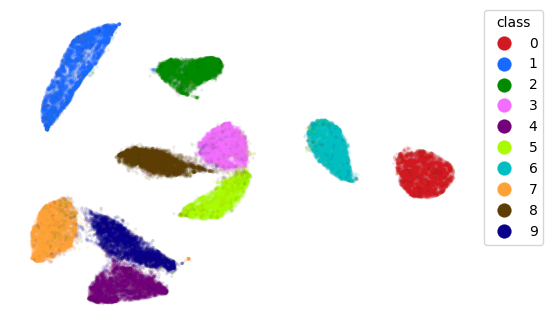

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.6140485714285715), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.34940341114997864, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.11866952380952381), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.17919342857142864), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.26281152380952383), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [3]:
pl.standard_eval(
    custom_umap(UMAP, embedder_name="My Custom UMAP"),
    dataset="mnist",
)

See: looks like UMAP.

## Square Loss Example

This example applies a square loss to the affinities, rather than the cross entropy. Here we don't
need the `grad_args` which simplifies things a bit.

In [4]:
from typing import Any


def squmap_grad_coeff_attr(d2: float, grad_args: Any) -> float:
    return -2.0 * pow(1.0 + d2, -2.0)


def squmap_grad_coeff_rep(d2: float, grad_args: Any) -> float:
    return 2.0 * pow(1.0 + d2, -3.0)


class SQUMAP(CustomGradientUMAP):
    def get_gradient_args(self):
        return None

    def __init__(self, **kwargs):
        super().__init__(
            custom_attr_func=squmap_grad_coeff_attr,
            custom_rep_func=squmap_grad_coeff_rep,
            **kwargs,
        )

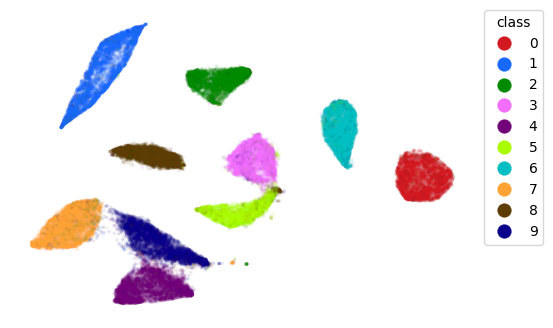

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.60824), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.32982927560806274, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.10733714285714287), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.17066885714285718), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.25738038095238097), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [5]:
pl.standard_eval(
    custom_umap(SQUMAP),
    dataset="mnist",
)

Surprisingly (perhaps?) not bad.

## Advanced Use Case

You can get quite a long way with just defining the attractive and repulsive functions and
customized `grad_args`. For examples see the submodules in `drnb.embed.umap`, for implementations
of HTUMAP (UMAP with a heavy-tail in the style of 
[heavy-tailed t-SNE](https://arxiv.org/abs/1902.05804)), NegUMAP (the "generalized NCE loss" version
of UMAP from [Contrastive learning unifies t-SNE and UMAP](https://arxiv.org/abs/2206.01816)) and
PaCUMAP (UMAP but with the kernel from [PaCMAP](https://arxiv.org/abs/2012.04456)).

However, the generalized NCE loss version of t-SNE (neg-t-SNE) needs a more complex treatment
because it has a parameter that depends on the number of samples in the dataset and the number
of negatives sampled, which varies per node due to UMAP's sampling implementation. While having
a hook to update the grad args before the optimization might be reasonable, having to add a hook
for each positive example is probably a bit much (and there is always the question of what data
to provide to these functions). In this specific case I am sure it is fine to just use the UMAP
`n_neg_samples` parameter, but the other way round is to provide your own epoch function via the
`custom_epoch_func` attribute in the superclass constructor. However you are on your own in terms
of implementing it correctly and making sure you call your new positive and negative functions
correctly. See `negtsne_epoch_func` in `drnb.embed.umap.negtsne` and compare it to `epoch_func` in 
`drnb.embed.umap.custom`.

Also if you want to dynamically update `grad_args`, you can't use a `NamedTuple` for that. You will
need to use a numba `jitclass`. See the `NegTsneGradientArgs` definition again in 
`drnb.embed.umap.negtsne`.

Output from some these can be found in `htumap.ipynb` and `negumap.ipynb` notebooks.



## More SqUMAP Output

So below are some more examples of the square-loss UMAP below in case you are curious how it performs.

In [6]:
squmap = custom_umap(SQUMAP)

[12:15:19] WARNING  151 nearest neighbors requested but only 150 items are available   ]8;id=853396;file:///home/james/dev/drnb-plugin/src/drnb/eval/nbrpres.py\nbrpres.py]8;;\:]8;id=268863;file:///home/james/dev/drnb-plugin/src/drnb/eval/nbrpres.py#75\75]8;;\

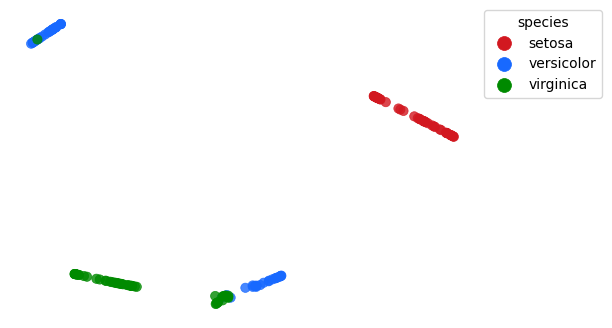

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7746666666666666), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.7030542492866516, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.7266666666666666), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.8108000000000001), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=nan, info={'metric': 'euclidean', 'n_neighbors': 150})]

In [7]:
pl.standard_eval(
    squmap,
    dataset="iris",
)

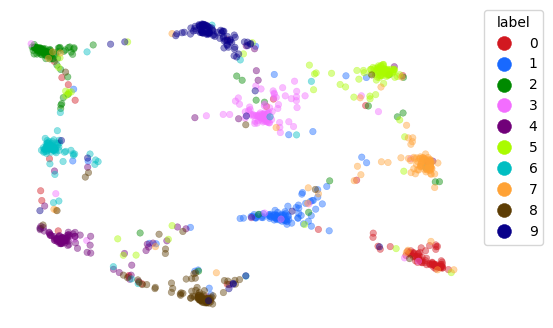

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.5848), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.269387811422348, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.3448), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.45441999999999994), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.51236), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [8]:
pl.standard_eval(
    squmap,
    dataset="s1k",
)

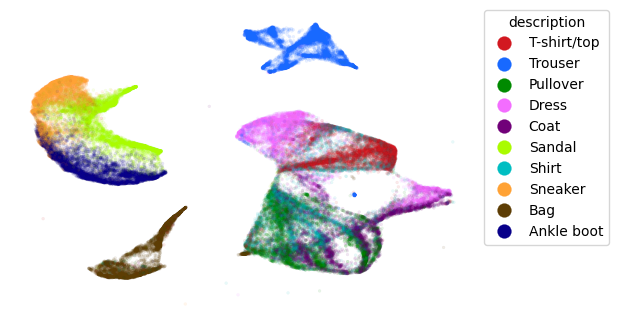

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.7269342857142858), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.5918315052986145, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.1162342857142857), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.18456257142857146), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.27399199999999996), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [9]:
pl.standard_eval(
    squmap,
    dataset="fashion",
)

Smaller datasets seem over-compressed, but the MNIST-scale ones seem ok.